In [93]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [94]:
df = pd.read_csv(
  "New_york.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [95]:
df.shape

(17379, 9)

In [13]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2011-01-01 00:00:00,16,0.24,0.2879,0.81,0.0,1,0,1,1
2011-01-01 01:00:00,40,0.22,0.2727,0.80,0.0,1,0,1,1
2011-01-01 02:00:00,32,0.22,0.2727,0.80,0.0,1,0,1,1
2011-01-01 03:00:00,13,0.24,0.2879,0.75,0.0,1,0,1,1
2011-01-01 04:00:00,1,0.24,0.2879,0.75,0.0,1,0,1,1


In [14]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

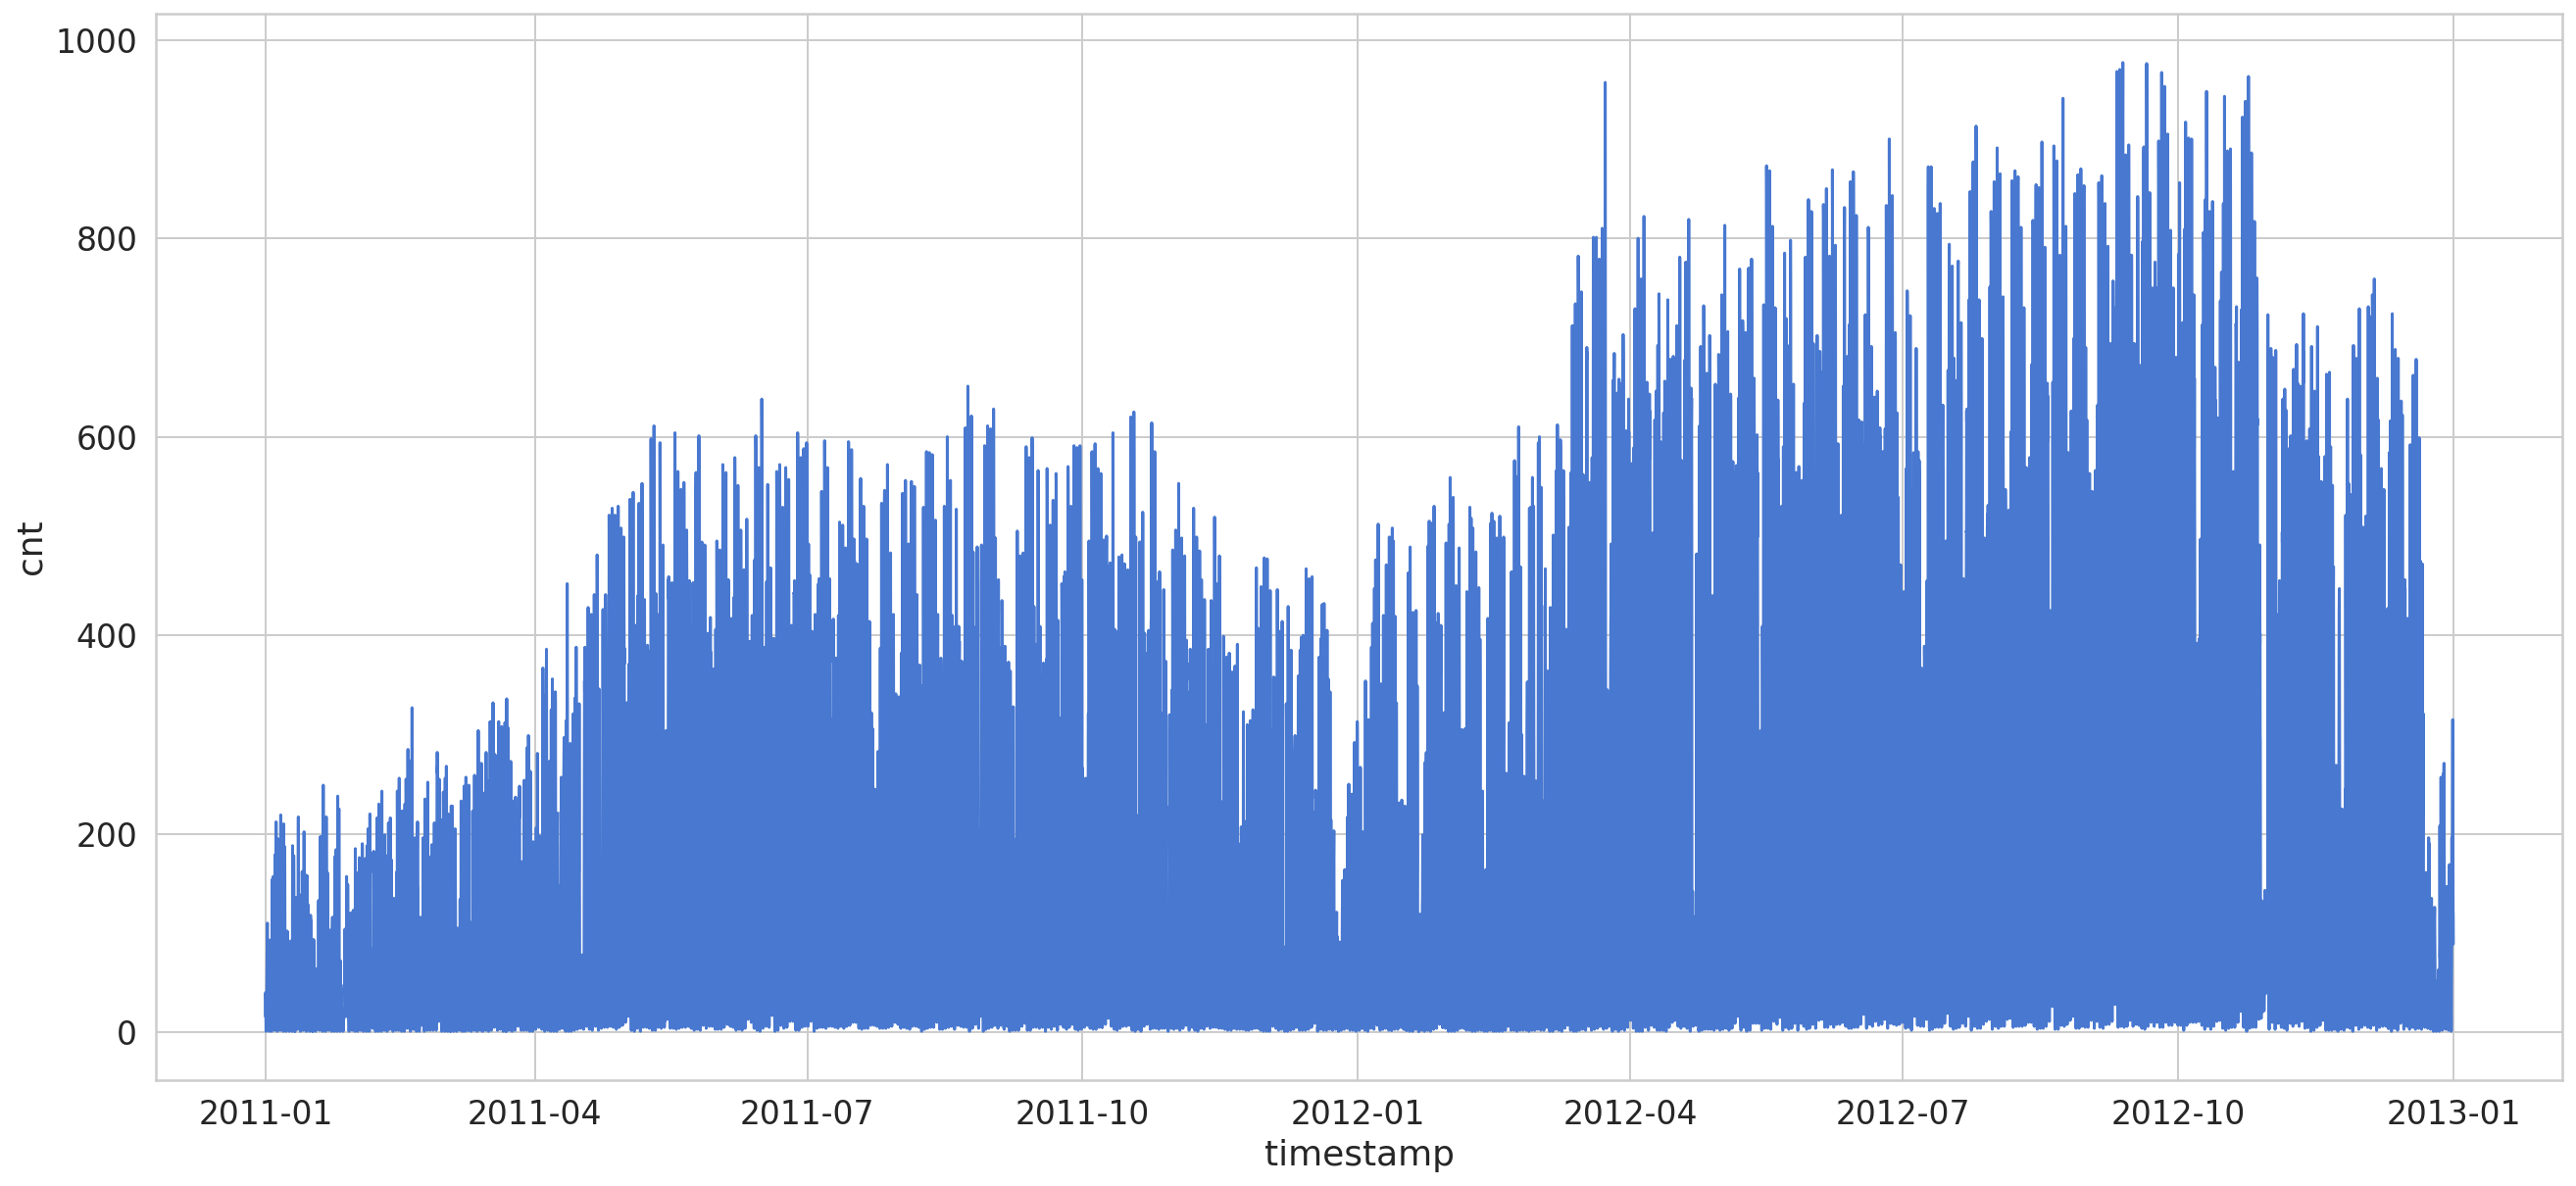

In [15]:
sns.lineplot(x=df.index, y="cnt", data=df);

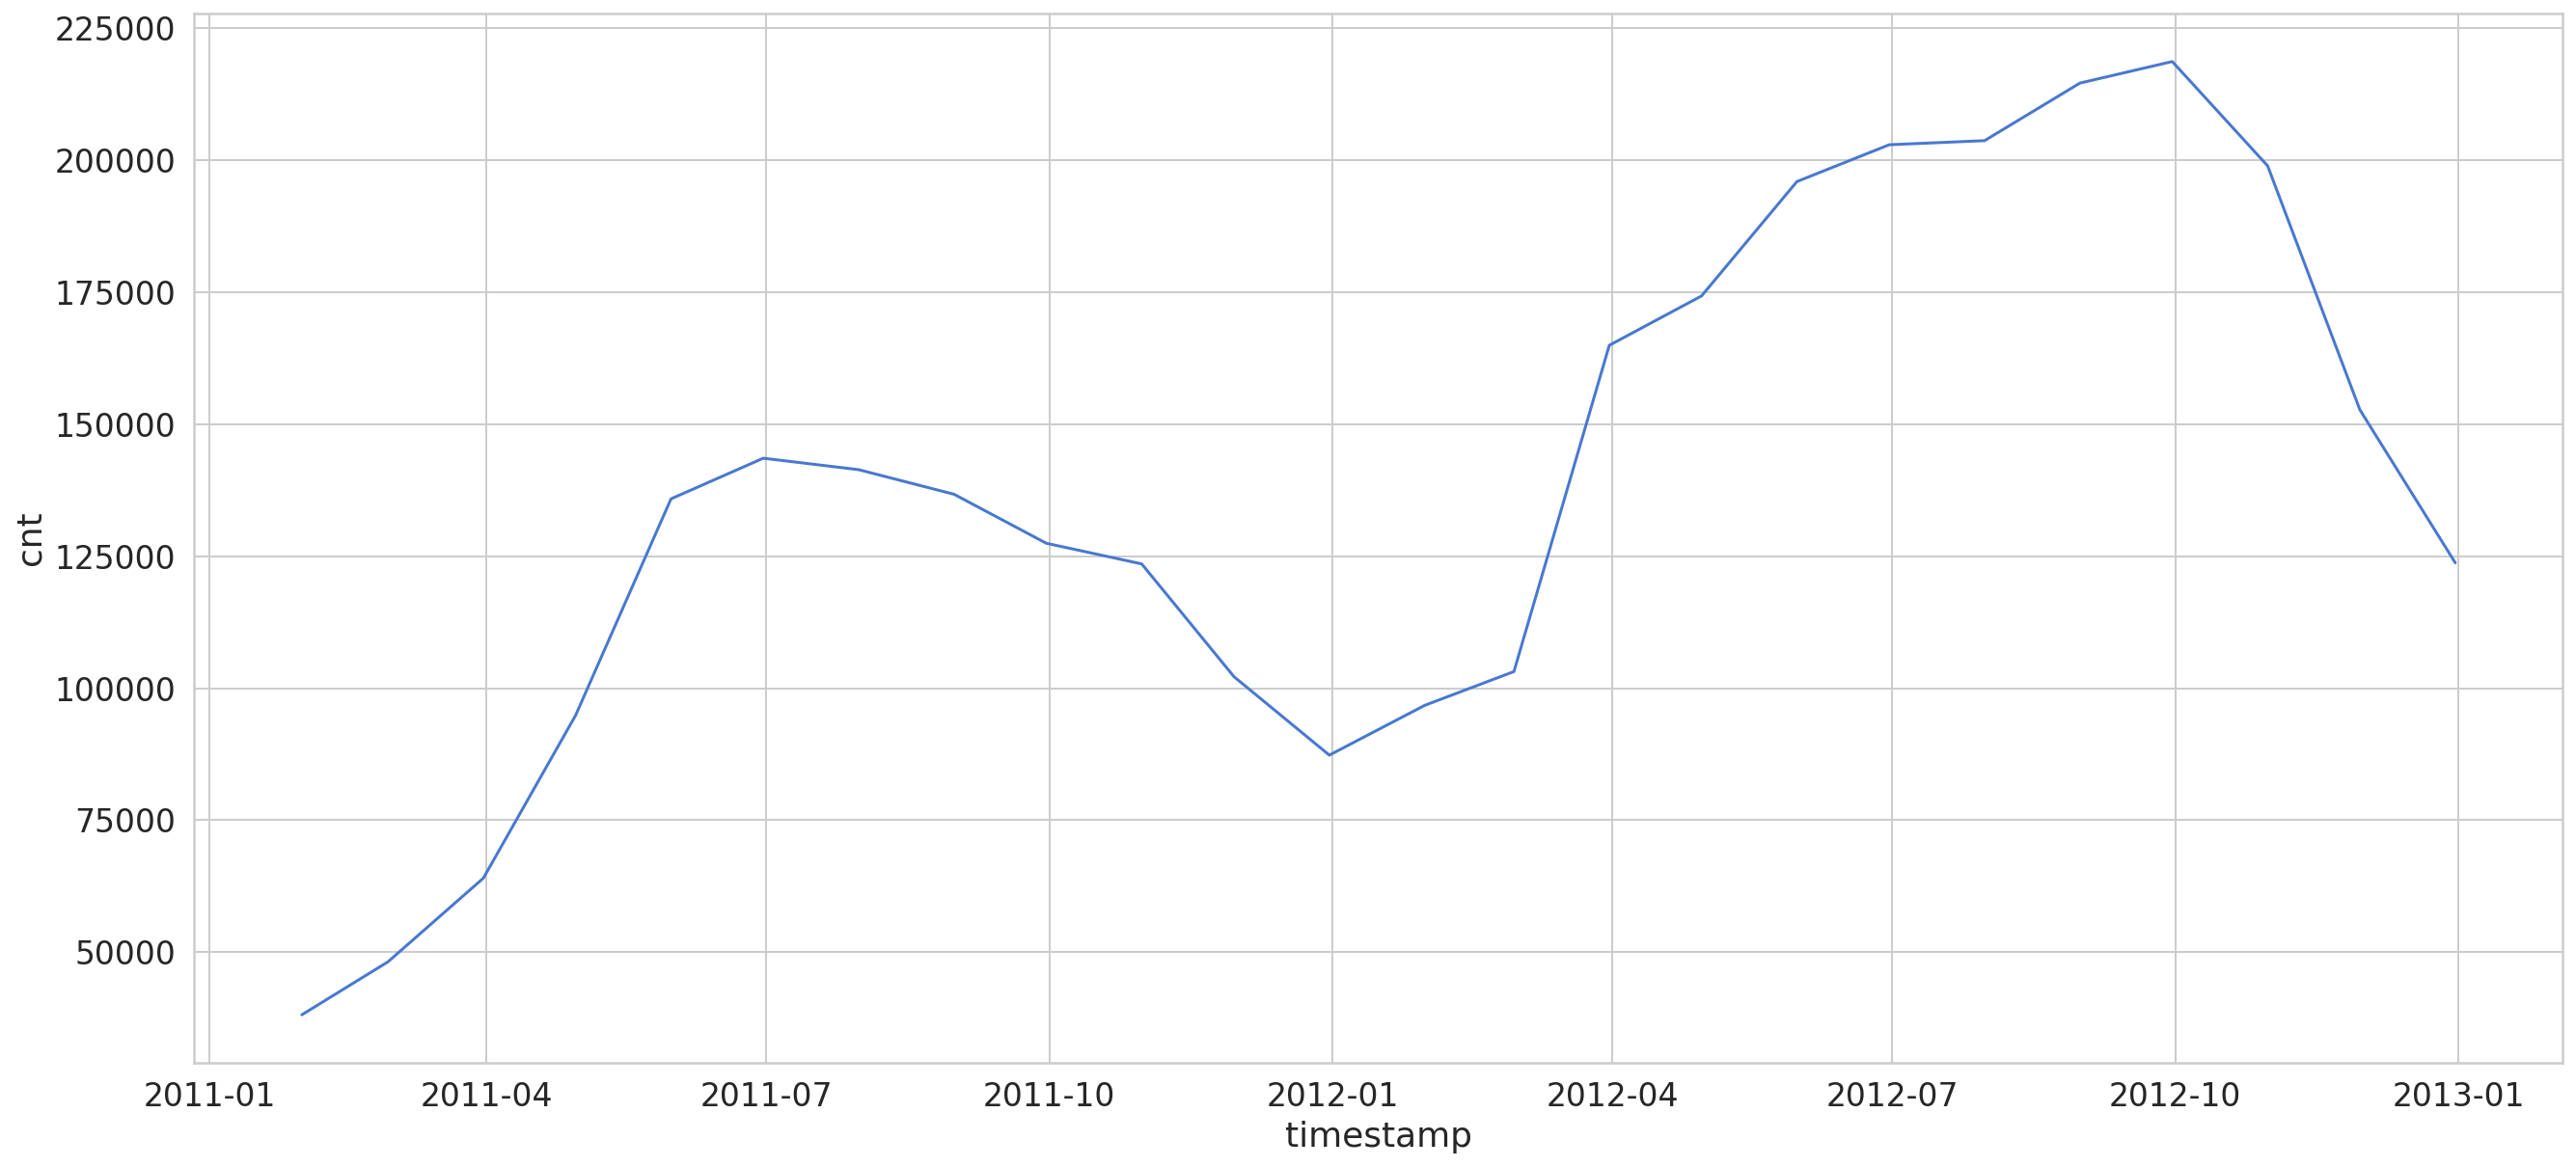

In [16]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

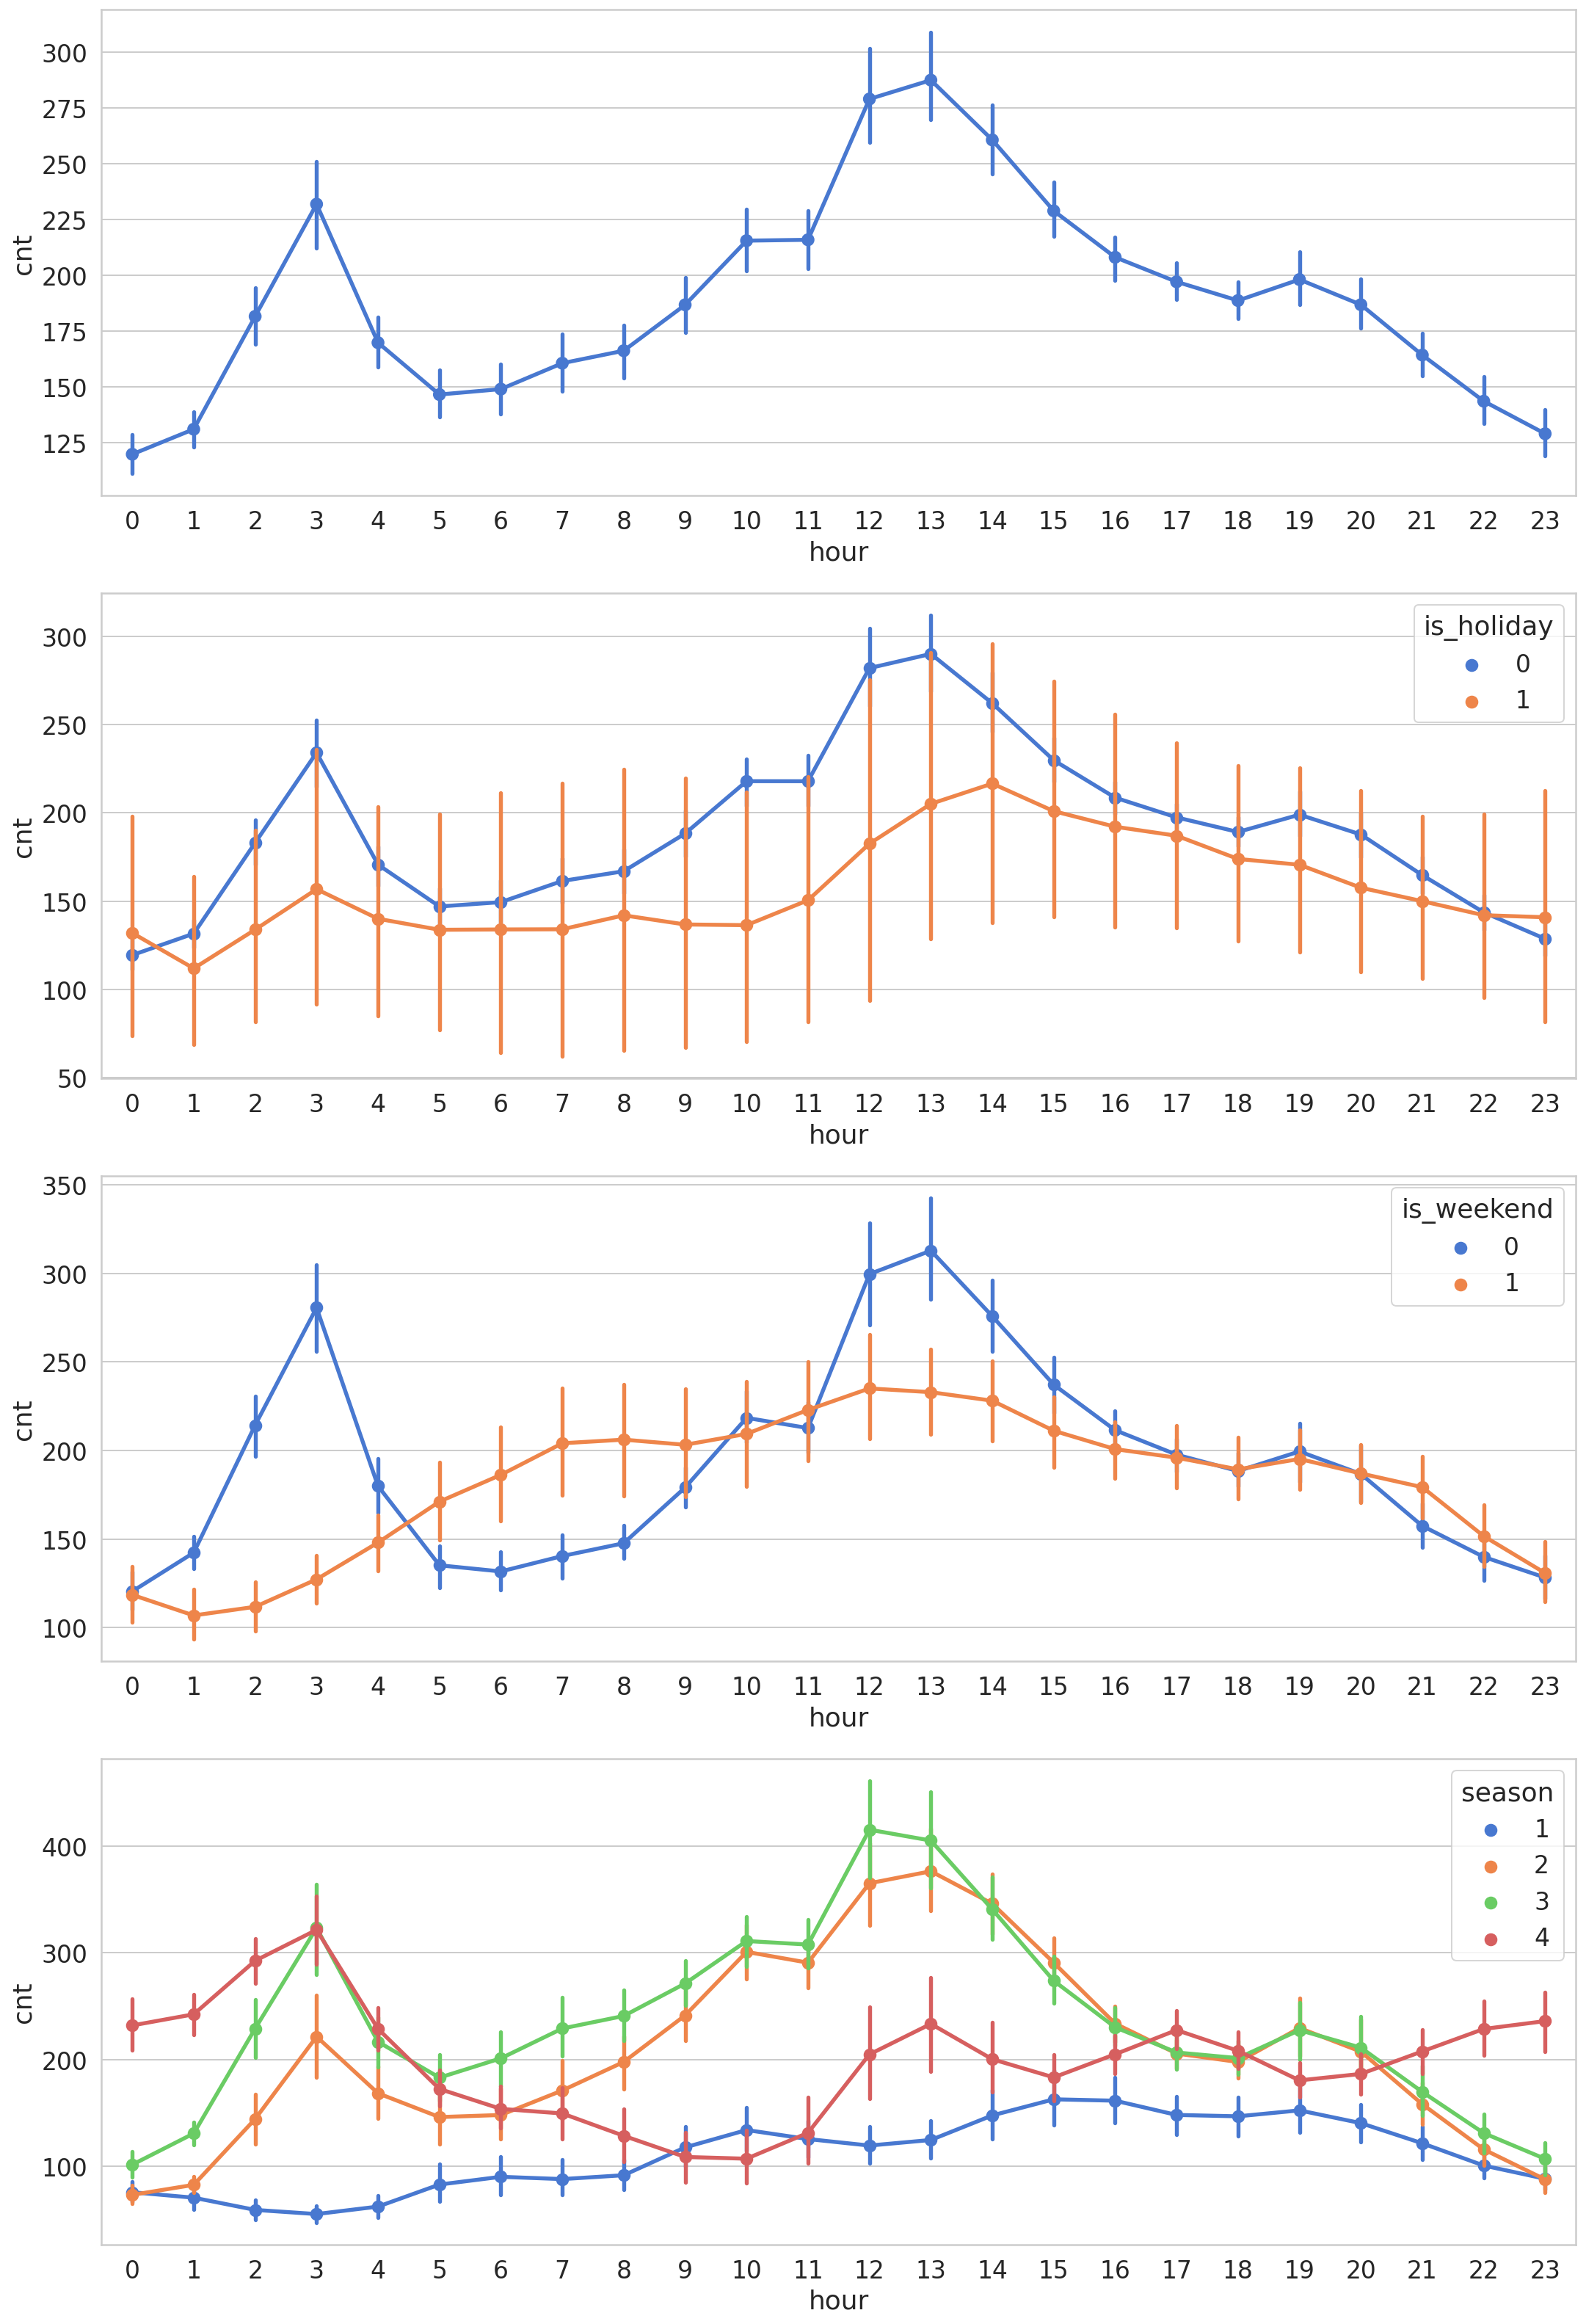

In [17]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

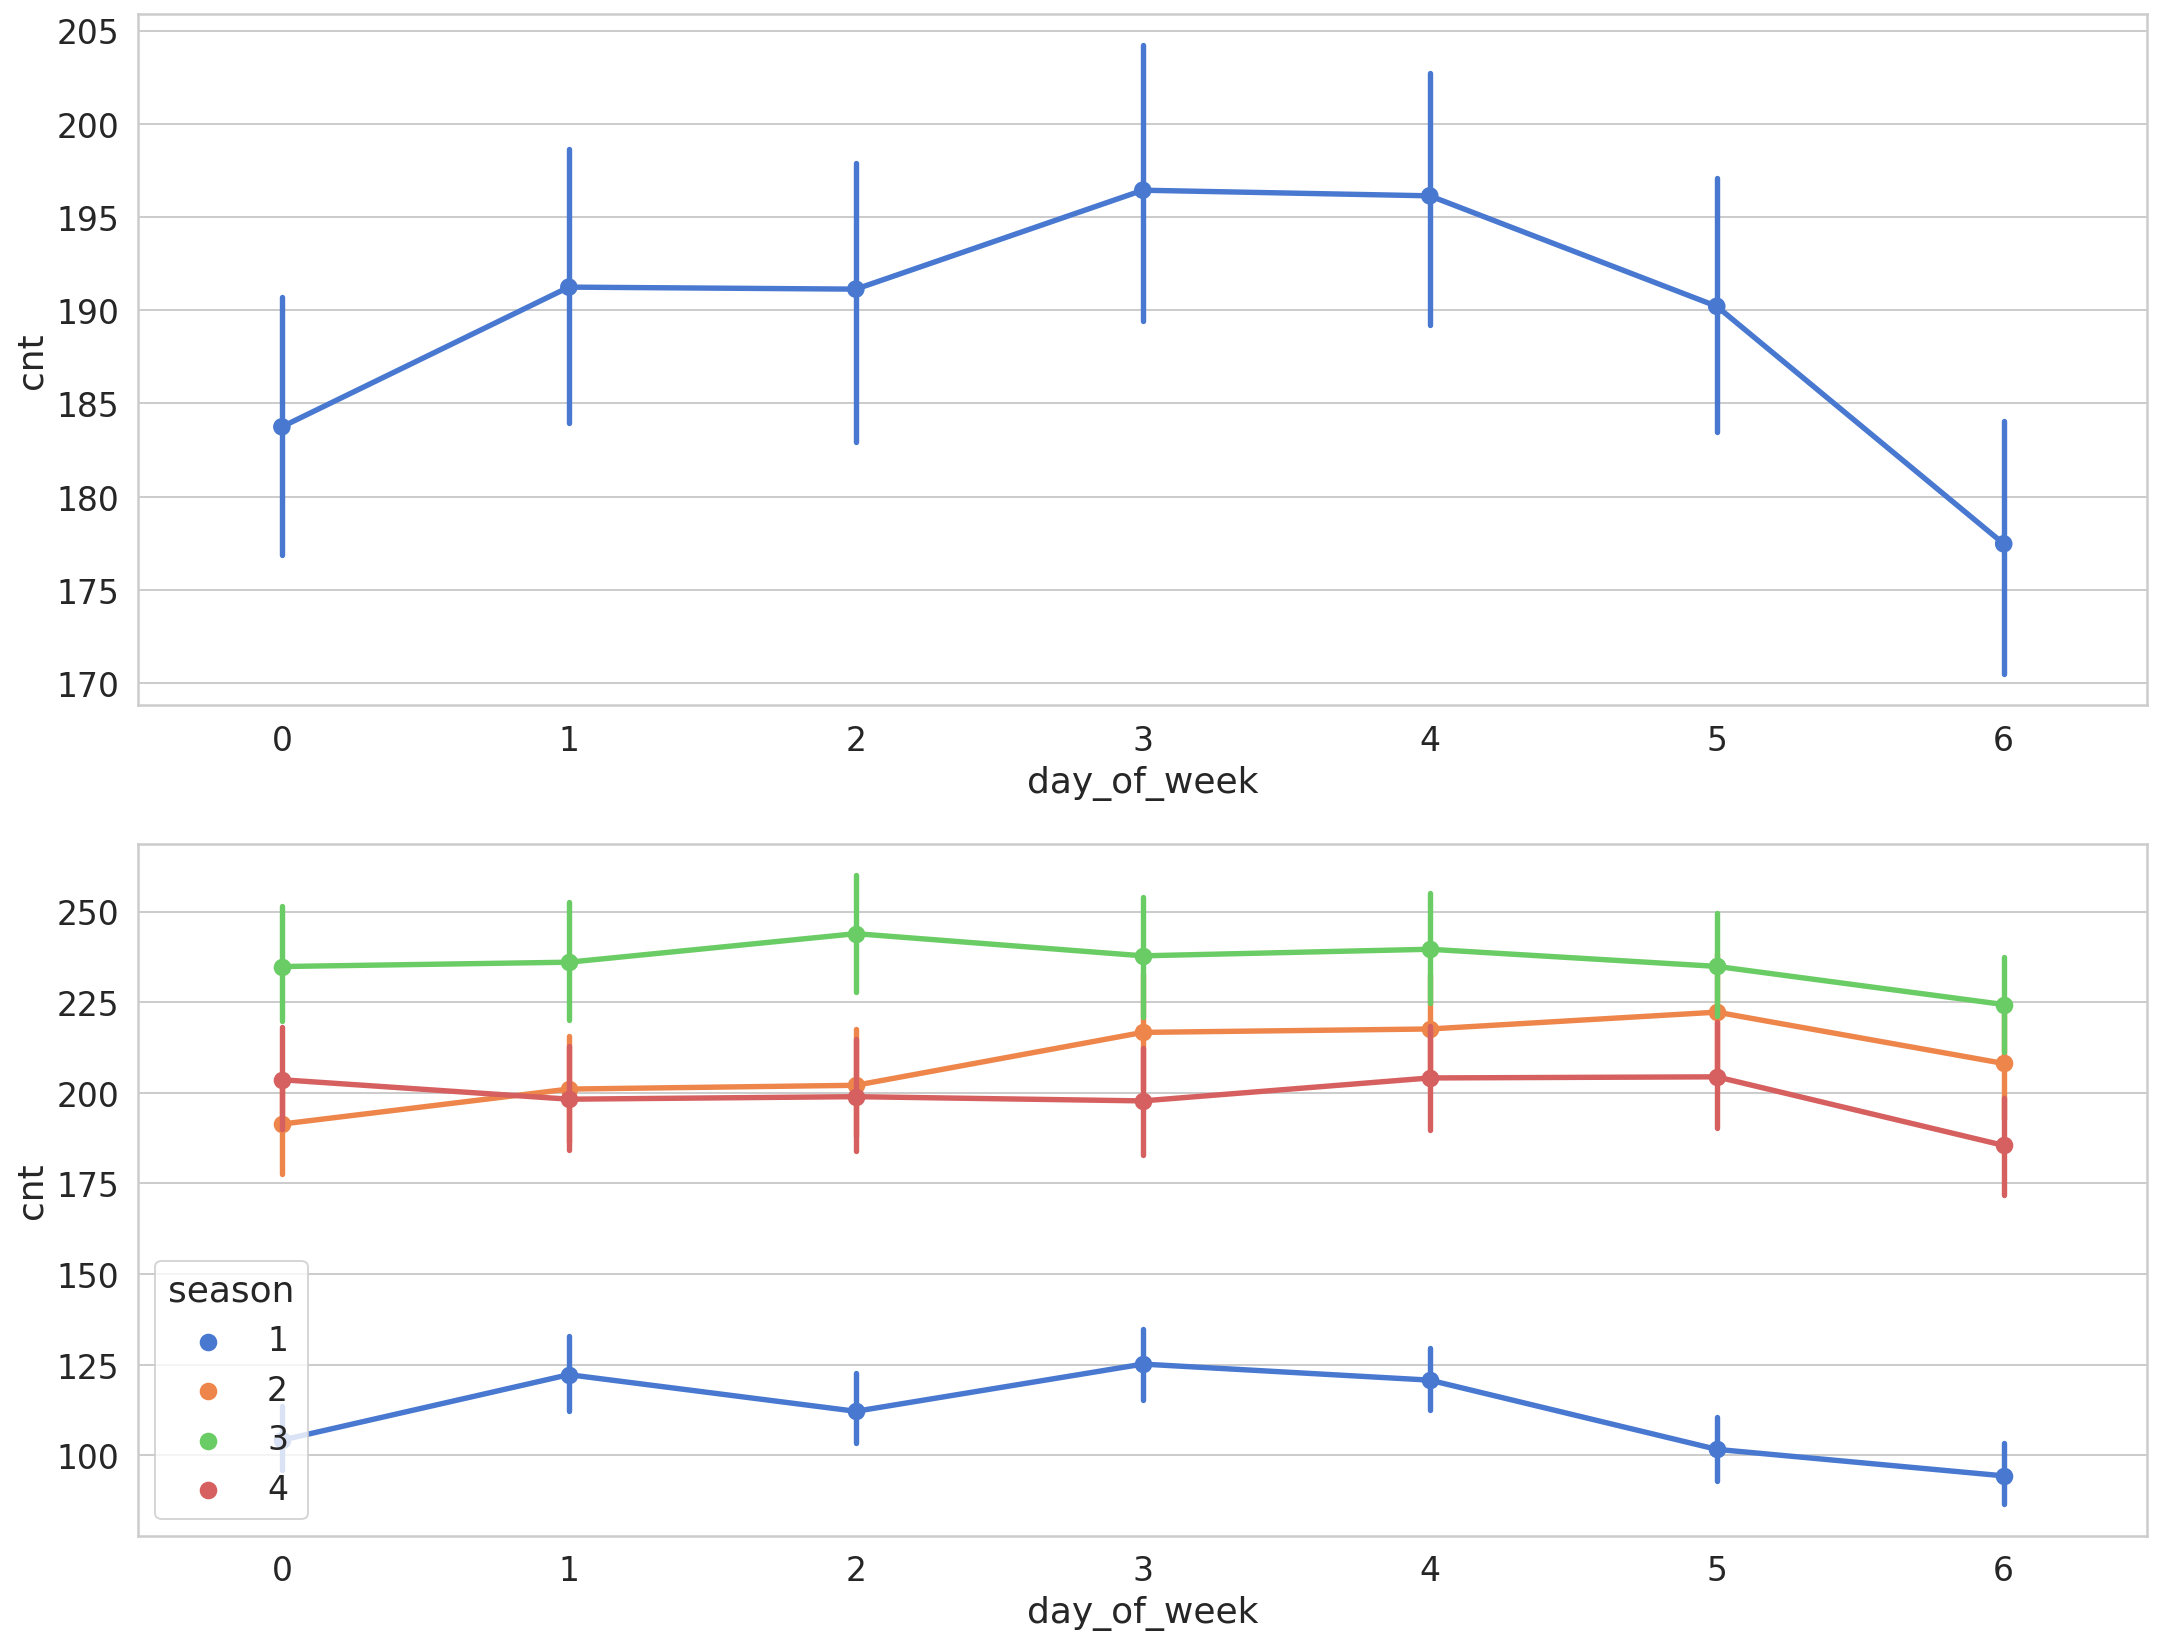

In [18]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

In [96]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15641 1738


# Preprocessing

In [97]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-97-92b06493bae2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [98]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [99]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15631, 10, 9) (15631,)


In [100]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [101]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
440/440 [==============================] - 12s 19ms/step - loss: 0.1250 - val_loss: 0.1123
Epoch 2/30
440/440 [==============================] - 9s 19ms/step - loss: 0.0614 - val_loss: 0.0624
Epoch 3/30
440/440 [==============================] - 8s 18ms/step - loss: 0.0434 - val_loss: 0.0596
Epoch 4/30
440/440 [==============================] - 8s 18ms/step - loss: 0.0402 - val_loss: 0.0532
Epoch 5/30
440/440 [==============================] - 8s 18ms/step - loss: 0.0374 - val_loss: 0.0535
Epoch 6/30
440/440 [==============================] - 8s 18ms/step - loss: 0.0346 - val_loss: 0.0494
Epoch 7/30
440/440 [==============================] - 8s 18ms/step - loss: 0.0312 - val_loss: 0.0479
Epoch 8/30
440/440 [==============================] - 8s 18ms/step - loss: 0.0294 - val_loss: 0.0500
Epoch 9/30
440/440 [==============================] - 8s 18ms/step - loss: 0.0277 - val_loss: 0.0502
Epoch 10/30
440/440 [==============================] - 8s 18ms/step - loss: 0.0269 - val_l

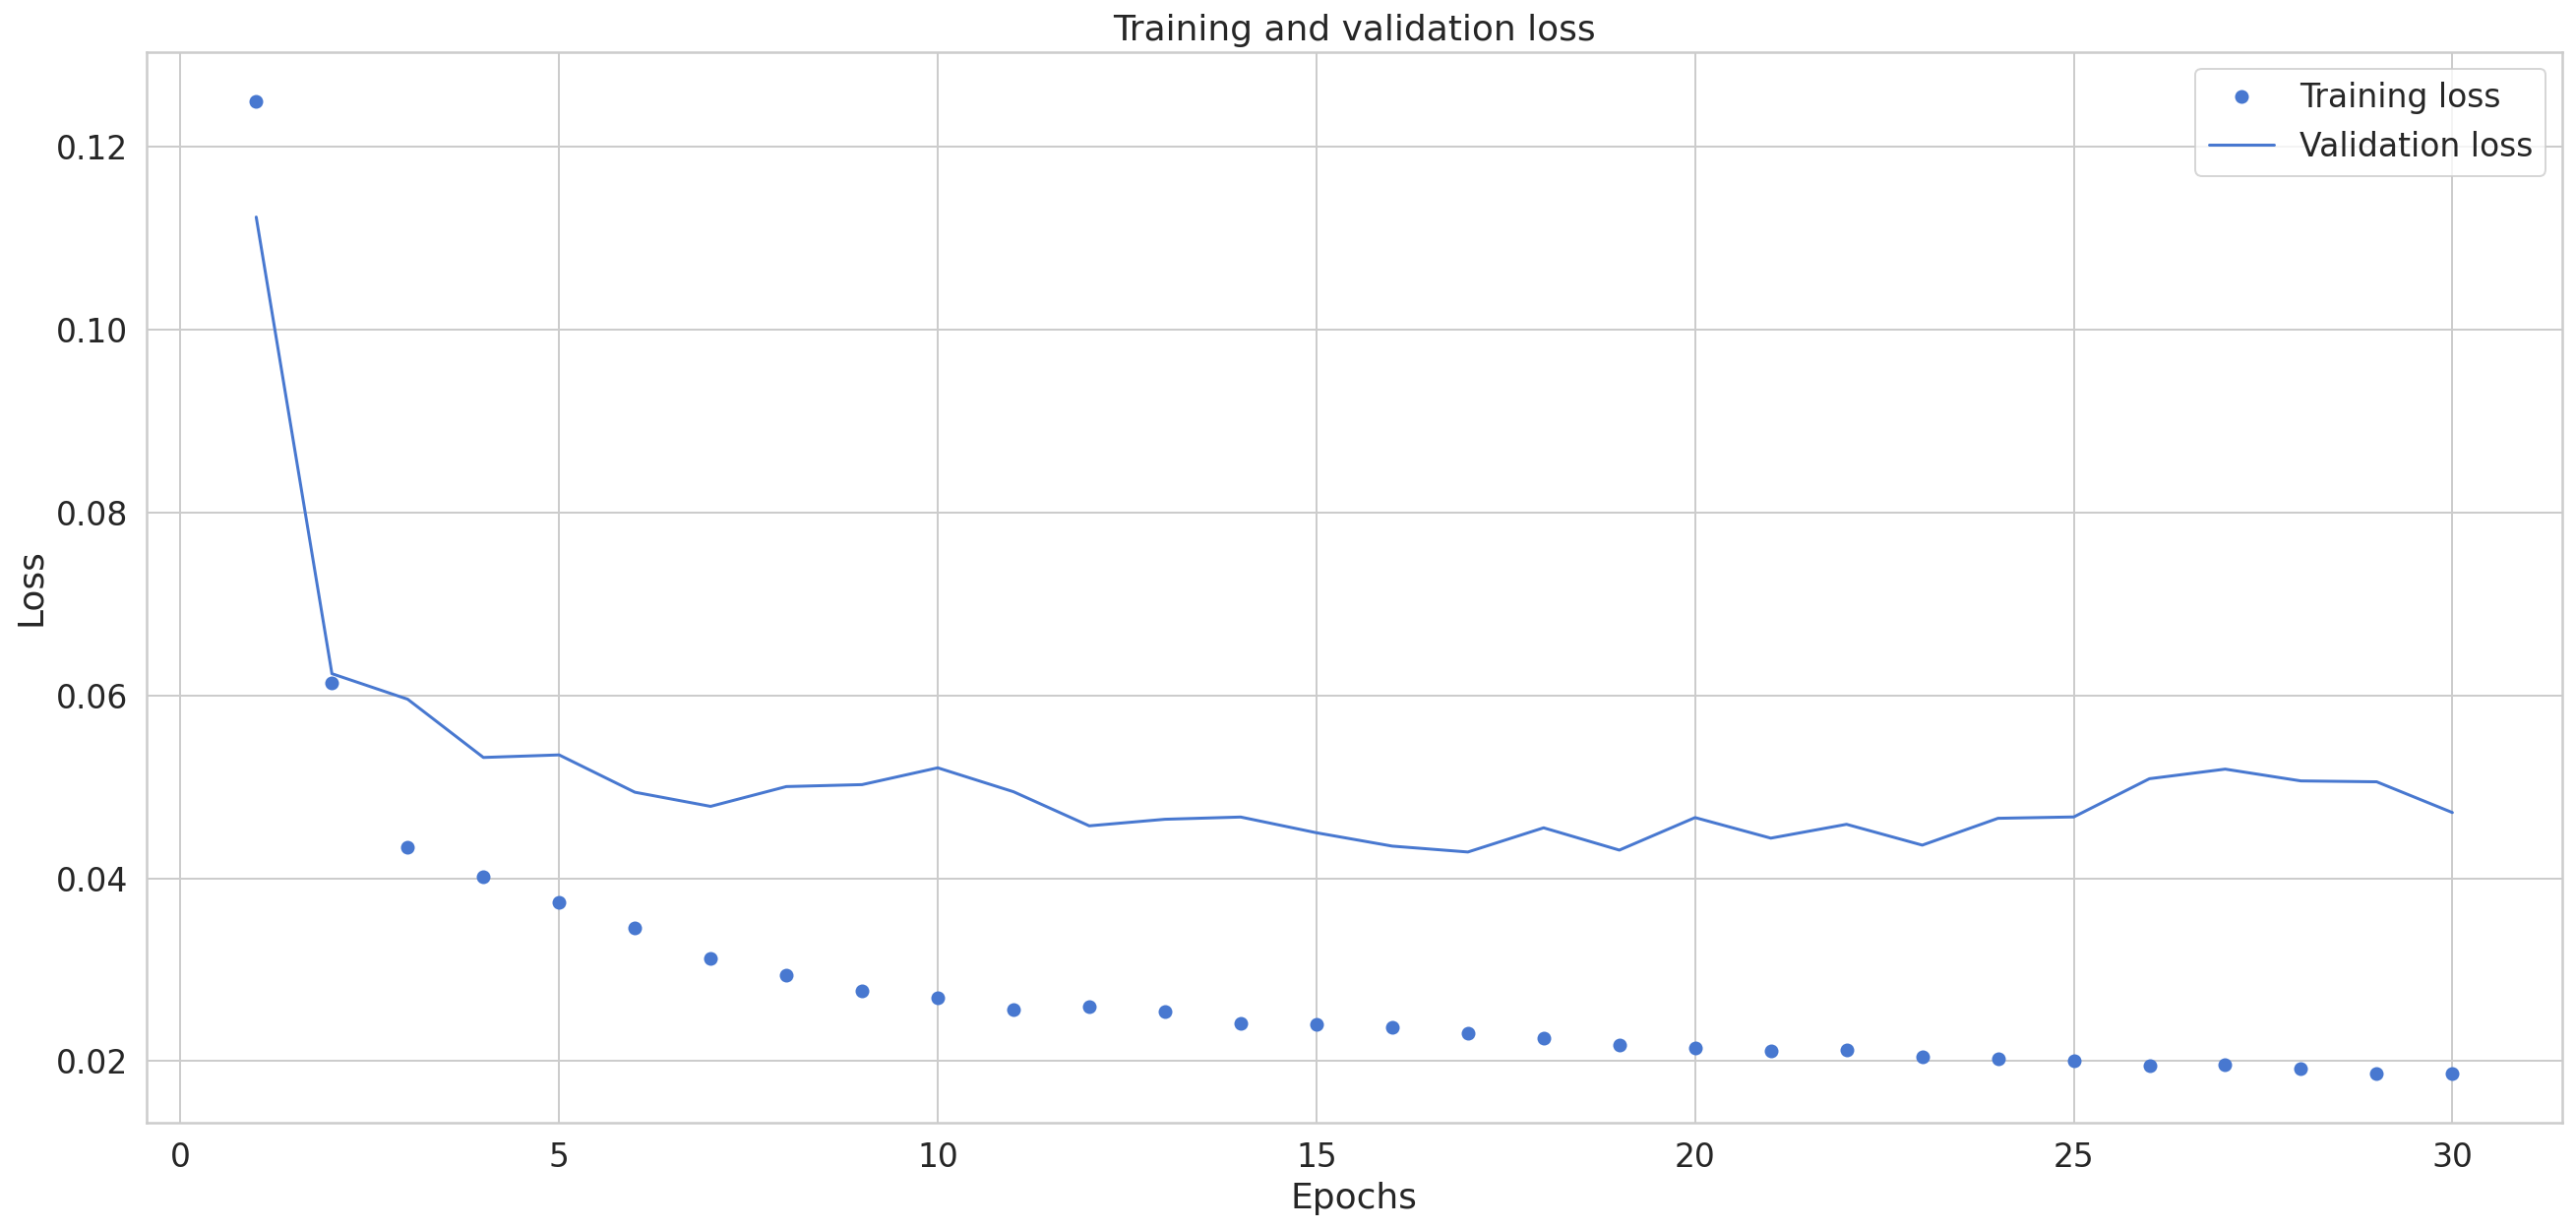

In [102]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [103]:
y_pred = model.predict(X_test)

54/54 [==============================] - 1s 5ms/step


In [104]:
train_mse = model.evaluate(X_train, y_train)
test_mse = model.evaluate(X_test, y_test)
 
# Print error
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

54/54 [==============================] - 0s 5ms/step - loss: 0.0329
Train set MSE =  0.04985525459051132
Test set MSE =  0.03290155529975891


In [107]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

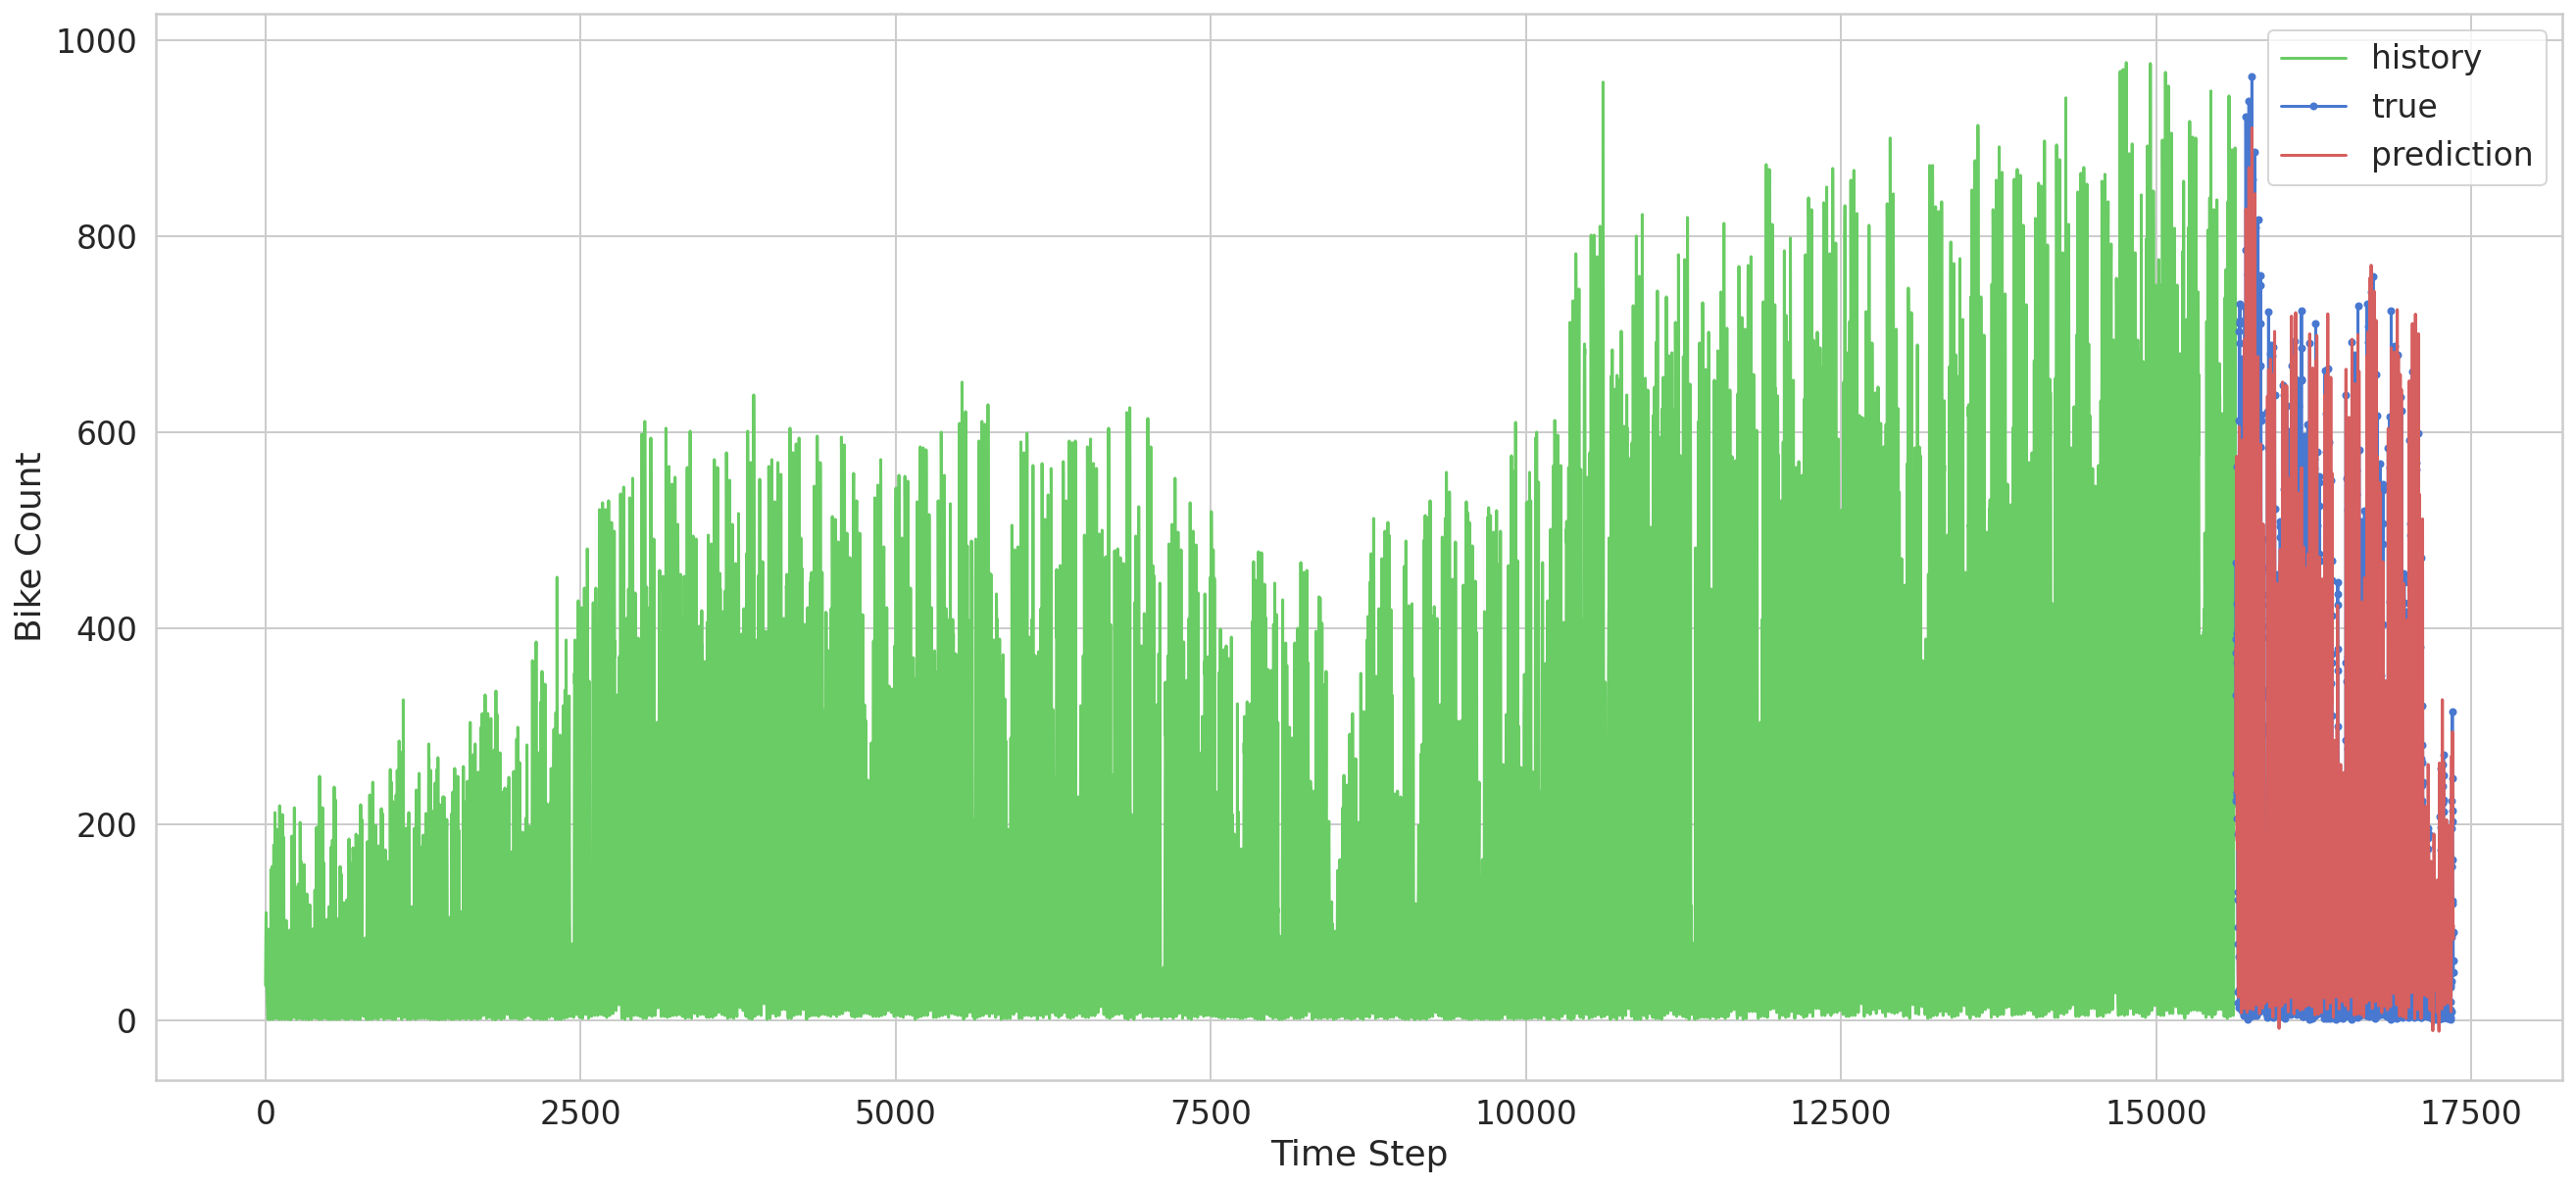

In [108]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

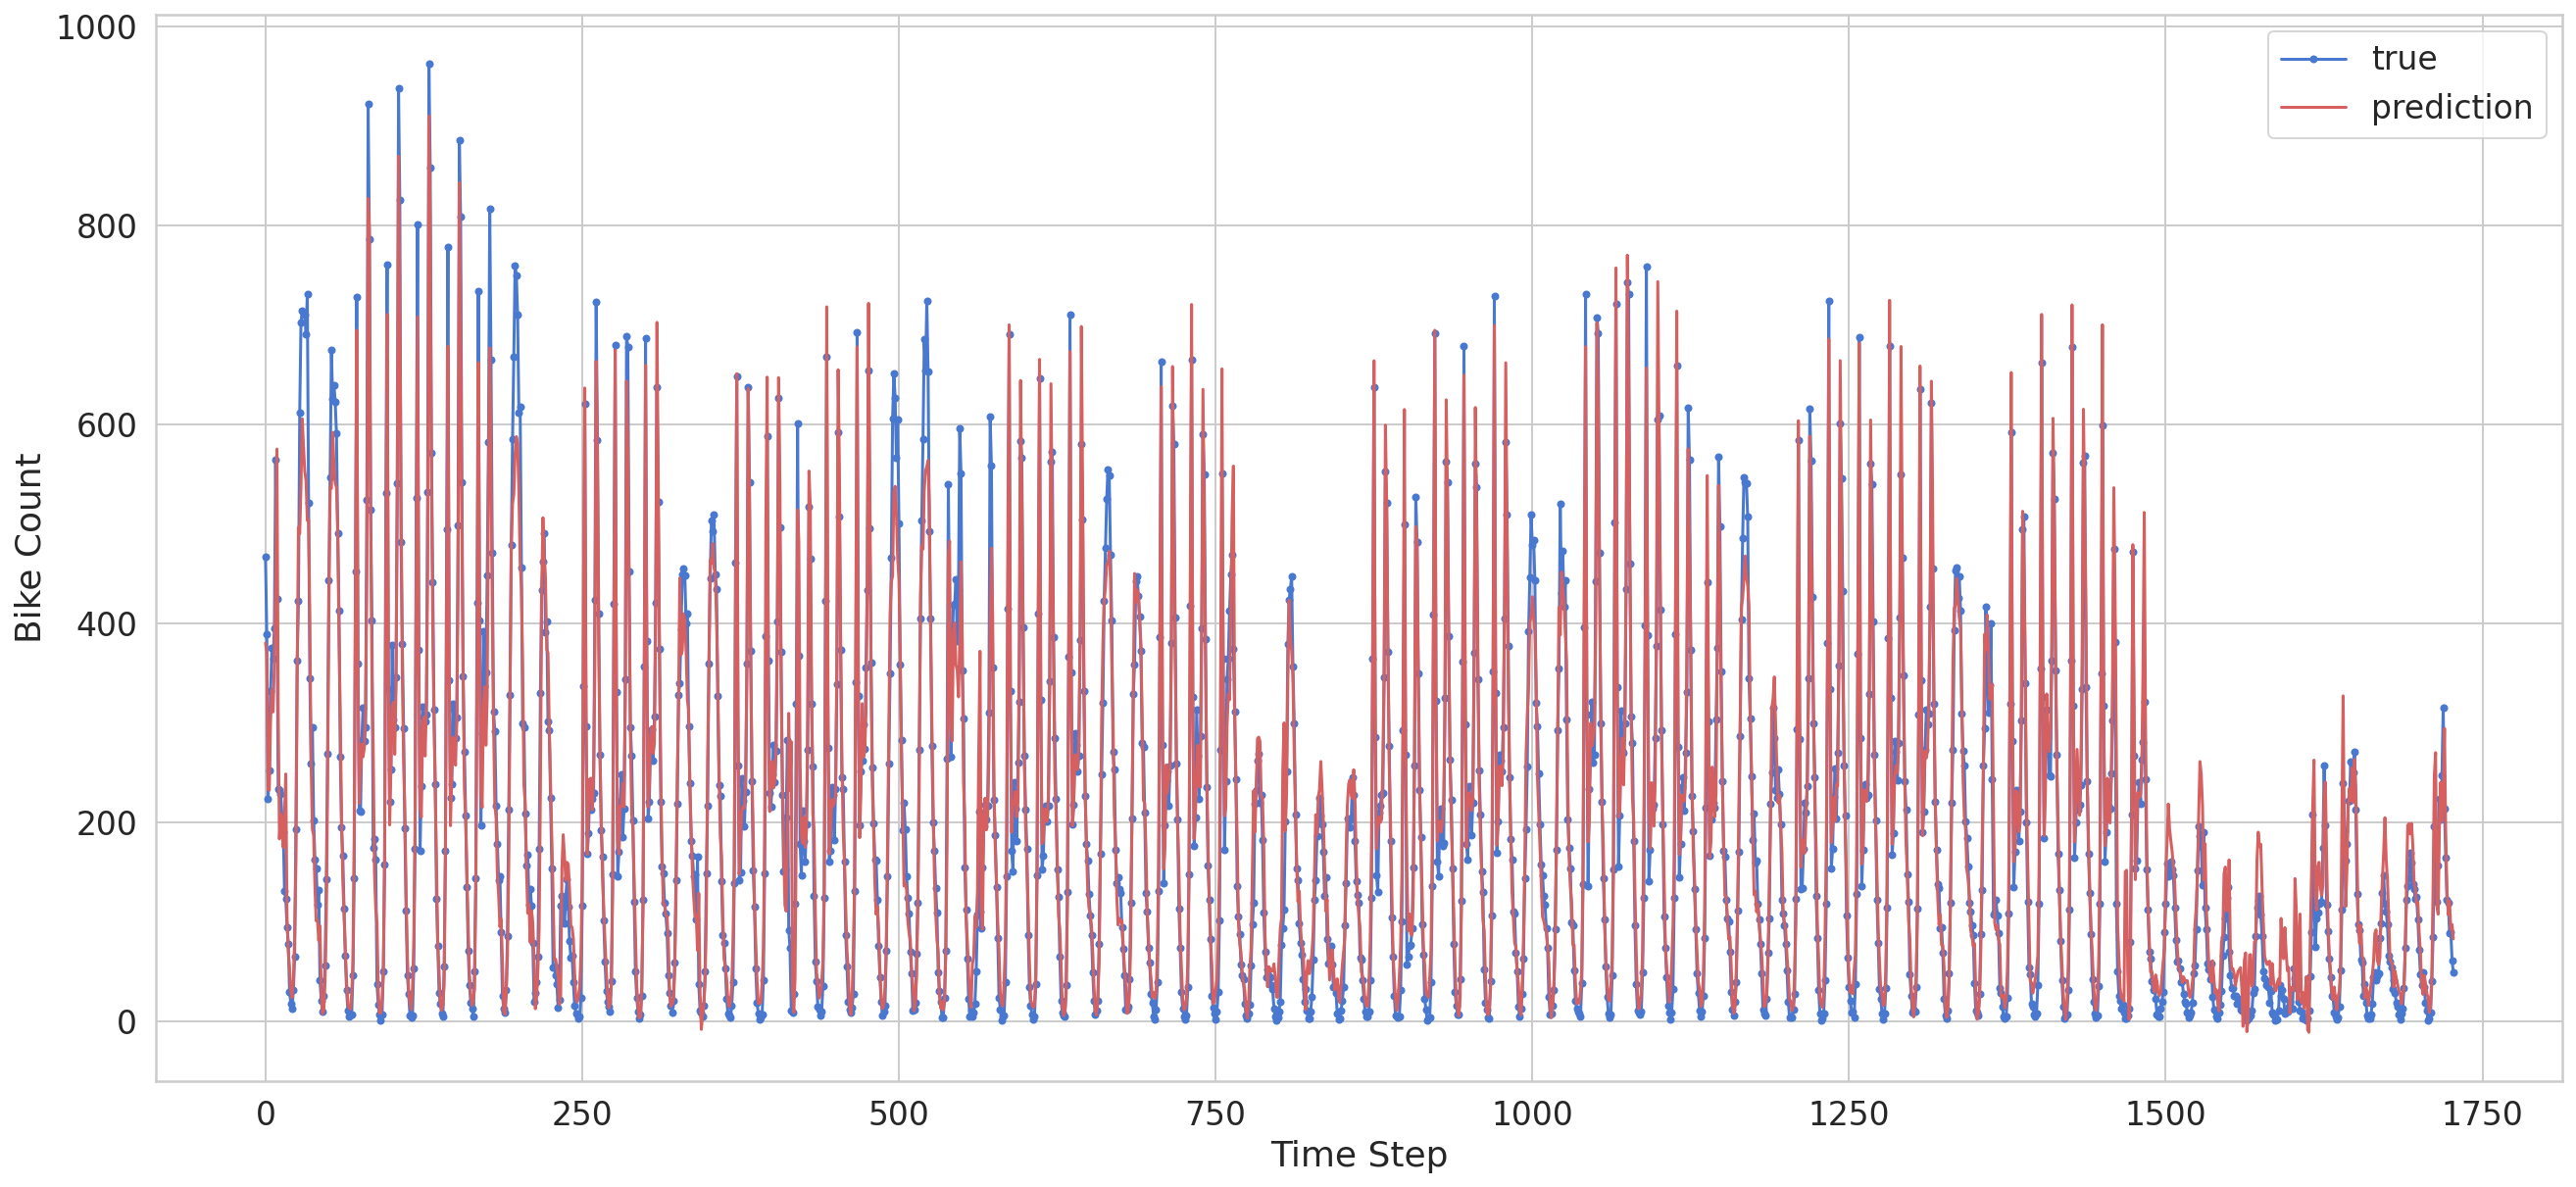

In [109]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [117]:
hidden_units = 2
epochs = 30
time_steps=20
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model
 
model_RNN = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(X_train.shape[1], X_train.shape[2]), 
                   activation=['tanh', 'tanh'])
model_RNN.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=2)
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(RNN_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')    
    return model    
 

Epoch 1/30
15631/15631 - 20s - loss: 0.1973 - 20s/epoch - 1ms/step
Epoch 2/30
15631/15631 - 20s - loss: 0.1497 - 20s/epoch - 1ms/step
Epoch 3/30
15631/15631 - 20s - loss: 0.1482 - 20s/epoch - 1ms/step
Epoch 4/30
15631/15631 - 21s - loss: 0.1475 - 21s/epoch - 1ms/step
Epoch 5/30
15631/15631 - 20s - loss: 0.1476 - 20s/epoch - 1ms/step
Epoch 6/30
15631/15631 - 20s - loss: 0.1473 - 20s/epoch - 1ms/step
Epoch 7/30
15631/15631 - 21s - loss: 0.1473 - 21s/epoch - 1ms/step
Epoch 8/30
15631/15631 - 20s - loss: 0.1473 - 20s/epoch - 1ms/step
Epoch 9/30
15631/15631 - 20s - loss: 0.1471 - 20s/epoch - 1ms/step
Epoch 10/30
15631/15631 - 20s - loss: 0.1472 - 20s/epoch - 1ms/step
Epoch 11/30
15631/15631 - 20s - loss: 0.1471 - 20s/epoch - 1ms/step
Epoch 12/30
15631/15631 - 20s - loss: 0.1472 - 20s/epoch - 1ms/step
Epoch 13/30
15631/15631 - 20s - loss: 0.1472 - 20s/epoch - 1ms/step
Epoch 14/30
15631/15631 - 20s - loss: 0.1471 - 20s/epoch - 1ms/step
Epoch 15/30
15631/15631 - 20s - loss: 0.1471 - 20s/epoch 

In [119]:
# Create the model with attention, train and evaluate
model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1, 
                                  input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh')
model_attention.summary()    
 
 
history=model_attention.fit(X_train, y_train,validation_split=0.1, epochs=epochs, batch_size=1, verbose=2)
 
# Evalute model
train_mse_attn = model_attention.evaluate(X_train, y_train)
test_mse_attn = model_attention.evaluate(X_test, y_test)
 
# Print error
print("Train set MSE with attention = ", train_mse_attn)
print("Test set MSE with attention = ", test_mse_attn)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 10, 9)]           0         
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 10, 2)             24        
                                                                 
 attention_13 (attention)    (None, 2)                 12        
                                                                 
 dense_18 (Dense)            (None, 1)                 3         
                                                                 
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
14067/14067 - 21s - loss: 0.3237 - val_loss: 0.6196 - 21s/epoch - 2ms/step
Epoch 2/30
14067/14067 - 22s - loss: 0.1696 - val_loss: 0.5288 - 22s/epoch - 2ms/step
Epoch 3/30
14067/14067

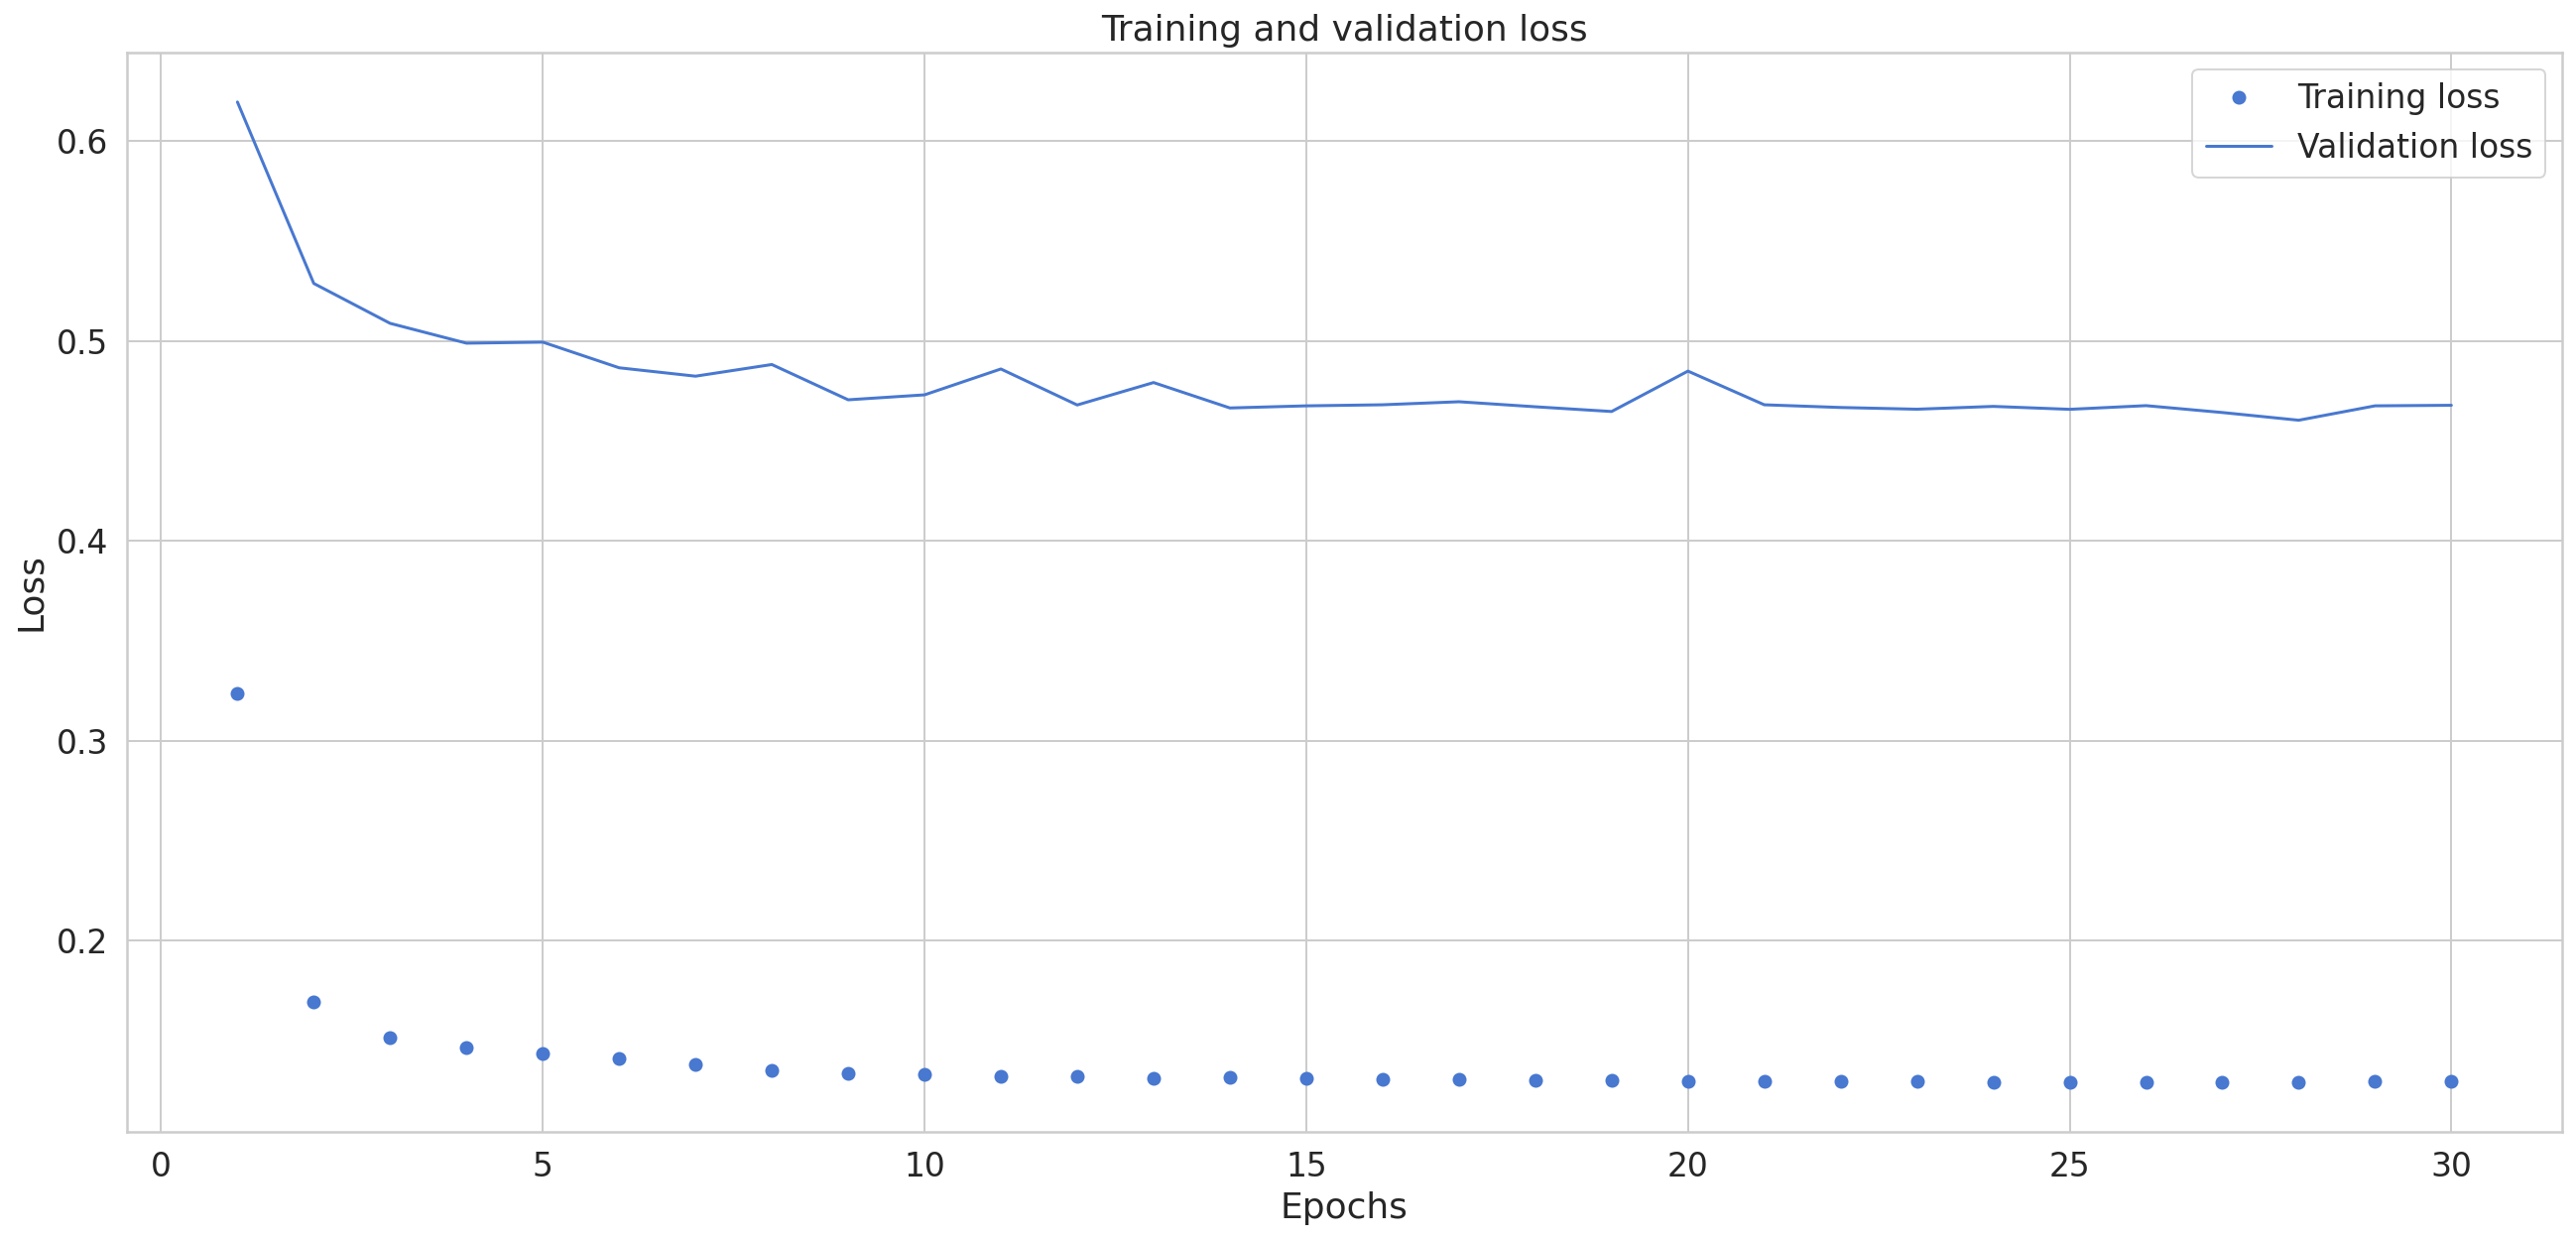

In [120]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()